### Necessary import

In [1]:
import os
from collections import defaultdict
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

from lib.utils import set_seed,get_sigwgan_experiment_dir,to_numpy
from lib.augmentations import parse_augmentations
from lib.distance.sigw1metric import SigW1Metric,compute_expected_signature
from lib.datasets import get_stock_price, train_test_split
from lib.network import get_generator, get_discriminator
from lib.test_metrics import get_standard_test_metrics
from lib.plot import plot_signature

### Hyperparameter

In [2]:
sigwgan_config = {
    "batch_size": 8,
    "epoch": 256,
    "depth": 4,
    "lr_generator": 5e-5,
    "lr_discriminator" : 5e-5,
    "window_size" : 3,
    "augmentations": [
        {"name":  "LeadLag"},
    ],
    "device" : 'cuda:0' if torch.cuda.is_available() else 'cpu',
}
data_config = {
    'ticker' : '^GSPC',
    'interval' : '1mo',
    'column' : 0,  #Open
    'window_size' : 3,
    'dir' : 'datasets',
    'subdir' : 'stock',
}
D_config = {
    "discriminator_type": "ResFNN",
    "hidden_dims": [20,20],
}
G_config = {
    "generator_type": "LogSigRNN",
    "hidden_dim": 50,
    "augmentations": [
        {"name":  "LeadLag"},
    ],
    "depth": 4,
    "input_dim": 3,
    "len_noise": 1000,
    "len_interval_u": 50,
    "init_fixed": True
}
print(sigwgan_config['device'])

set_seed(2024)

cuda:0


### Load data

In [3]:
x_real_rolled = get_stock_price(data_config)
x_real_rolled = x_real_rolled.to(sigwgan_config['device'])
print('Total data: ', list(x_real_rolled.shape))

x_real_train, x_real_test = train_test_split(x_real_rolled, train_test_ratio=0.8, device=sigwgan_config['device'])
x_real_dim: int = x_real_rolled.shape[2]
wgan_input_dim = x_real_dim * data_config['window_size']

print("D input dim: {}".format(wgan_input_dim)) # D output dim is always 1
print("G output dim: {}".format(x_real_dim)) 

Rolled data for training, shape torch.Size([286, 3, 1])
Total data:  [286, 3, 1]
D input dim: 3
G output dim: 1


### SigWGAN

In [4]:
from lib.model.base import Base
from copy import deepcopy

class SigWGAN(nn.Module): 
    def __init__(self, D, G, lr_generator, lr_discriminator, epoch, batch_size, depth, x_real_rolled, augmentations, 
                 test_metrics_train, test_metrics_test, normalise_sig: bool = True, mask_rate=0.01,
                 **kwargs):
        super(SigWGAN, self).__init__()
        self.sig_w1_metric = SigW1Metric(depth=depth, x_real=x_real_rolled, augmentations=augmentations,
                                         mask_rate=mask_rate, normalise=normalise_sig)
        self.D = D
        self.G = G

        self.lr_generator = lr_generator
        self.lr_discriminator = lr_discriminator
        self.epoch = epoch
        self.batch_size = batch_size
        self.depth = depth
        self.augmentations = augmentations
        self.test_metrics_train = test_metrics_train
        self.test_metrics_test = test_metrics_test

        self.G_optimizer = torch.optim.Adam(self.G.parameters(), lr=self.lr_generator)
        self.D_optimizer = torch.optim.Adam(self.D.parameters(), lr=self.lr_discriminator, betas=(0, 0.9))
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.G_optimizer, gamma=0.95, step_size=128)

        self.losses_history = defaultdict(list)

    def fit(self, device):
        self.G.to(device)
        best_loss = 10**10
        pbar = tqdm(range(self.epoch))
        for j in pbar:
            self.G_optimizer.zero_grad()
            x_fake = self.G(
                batch_size=self.batch_size, window_size=self.sig_w1_metric.window_size, device=device
            )
            loss = self.sig_w1_metric(x_fake)  # E[S(x_real)] - E[S(X_fake)]
            loss.backward()
            best_loss = loss.item() if j == 0 else best_loss

            pbar.set_description("sig-w1 loss: {:1.6e}".format(loss.item()))
            self.G_optimizer.step()
            self.scheduler.step()
            self.losses_history['sig_w1_loss'].append(loss.item())
            self.evaluate(x_fake)

            if loss < best_loss:
               best_G = deepcopy(self.G.state_dict())
               best_loss = loss

        self.G.load_state_dict(best_G)  # retrieve the best generator
    def evaluate(self, x_fake):
        # self.losses_history['time'].append(time.time() - self.init_time)
        with torch.no_grad():
            for test_metric in self.test_metrics_train:
                test_metric(x_fake)
                loss = to_numpy(test_metric.loss_componentwise)
                if len(loss.shape) == 1:
                    loss = loss[..., None]
                self.losses_history[test_metric.name + '_train'].append(loss)
            for test_metric in self.test_metrics_test:
                test_metric(x_fake)
                loss = to_numpy(test_metric.loss_componentwise)
                if len(loss.shape) == 1:
                    loss = loss[..., None]
                self.losses_history[test_metric.name + '_test'].append(loss)

### Set discriminator and generator

In [5]:
D_config.update(input_dim=wgan_input_dim)
print(D_config)
G_config.update(output_dim=x_real_dim)
print(G_config)

if sigwgan_config.get('augmentations') is not None:
            sigwgan_config['augmentations'] = parse_augmentations(sigwgan_config.get('augmentations'))

if G_config.get('augmentations') is not None:
    G_config['augmentations'] = parse_augmentations(G_config.get('augmentations'))

D = get_discriminator(**D_config).to(sigwgan_config['device'])
G = get_generator(**G_config).to(sigwgan_config['device'])

{'discriminator_type': 'ResFNN', 'hidden_dims': [20, 20], 'input_dim': 3}
{'generator_type': 'LogSigRNN', 'hidden_dim': 50, 'augmentations': [{'name': 'LeadLag'}], 'depth': 4, 'input_dim': 3, 'len_noise': 1000, 'len_interval_u': 50, 'init_fixed': True, 'output_dim': 1}


In [6]:
test_metrics_train = get_standard_test_metrics(x_real_train)
test_metrics_test = get_standard_test_metrics(x_real_test)

print(test_metrics_train)
print(test_metrics_test)

[SigW1Loss()]
[SigW1Loss()]


In [7]:
SigWGAN = SigWGAN(D,G,x_real_rolled=x_real_rolled,
                  test_metrics_train=test_metrics_train,
                  test_metrics_test=test_metrics_test,
                  **sigwgan_config)

SigWGAN.fit(device=sigwgan_config['device'])

sig-w1 loss: 1.596829e-01: 100%|██████████| 256/256 [00:02<00:00, 97.99it/s] 


In [8]:
experiment_dir = get_sigwgan_experiment_dir("^GSPC", "LogSigRNN", 'SigWGAN', 2024)
loss_history = loss_history = os.path.join(experiment_dir, 'LossHistory')
os.makedirs(loss_history, exist_ok=True)

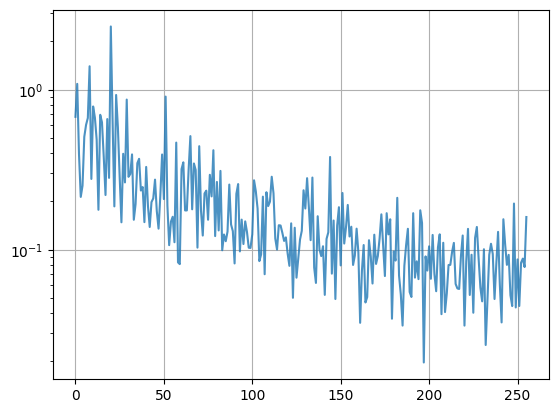

In [9]:
plt.plot(SigWGAN.losses_history['sig_w1_loss'], alpha=0.8)
plt.grid()
plt.yscale('log')
# plt.savefig(os.path.join(loss_history, 'sig_loss.png'))
plt.show()

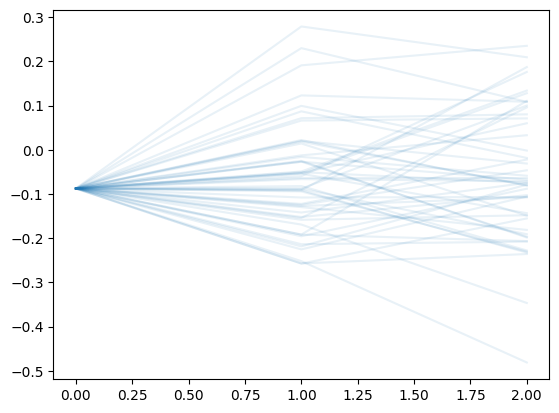

In [12]:
with torch.no_grad():
    x_fake = G(100, sigwgan_config['window_size'], sigwgan_config['device'])

for i in range(x_real_dim):
    plt.plot(to_numpy(x_fake[:50, :, i]).T, 'C%s' % i, alpha=0.1)


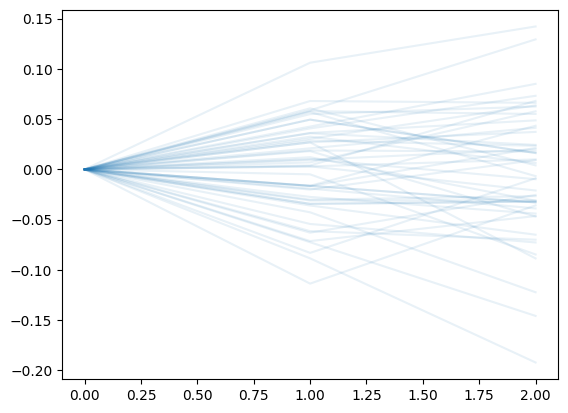

In [13]:
for i in range(x_real_dim):
    random_indices = torch.randint(0, x_real_rolled.shape[0], (50,))
    plt.plot(to_numpy(x_real_rolled[random_indices, :, i]).T, 'C%s' % i, alpha=0.1)

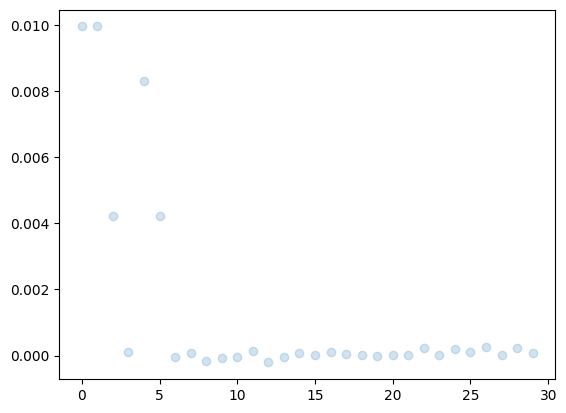

In [15]:
plot_signature(SigWGAN.sig_w1_metric.expected_signature_mu)
# plt.savefig(os.path.join(experiment_dir, 'sig_real.png'))

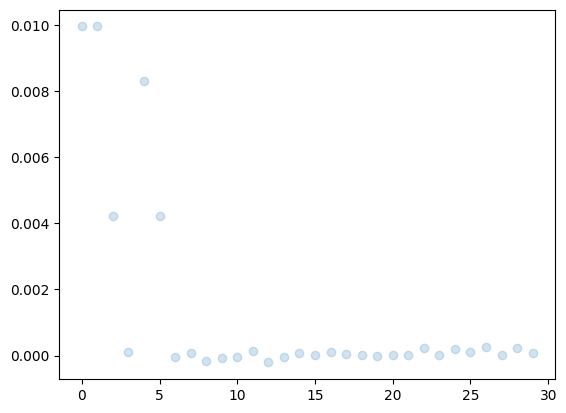

In [16]:
plot_signature(SigWGAN.sig_w1_metric.expected_signature_mu)

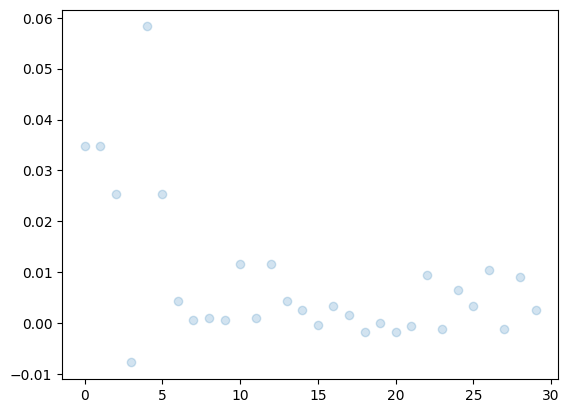

In [17]:
plot_signature(compute_expected_signature(x_fake,
                                        SigWGAN.sig_w1_metric.depth, SigWGAN.sig_w1_metric.augmentations))